Aanvraag / besluit classifier

In [118]:
import numpy as np
import math
from PIL import Image
from scipy import misc
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve

%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomUniform
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
 

from stats import list_stats, show_train_curves, show_prediction_list, show_prediction_images_new
# from stats import show_train_curves
from data import split_data
from examples.aanvraag_besluit.load_data import load_data_aanvraag
from image_display import show_image

# Hot reload packages
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset

In [47]:
img_dim = (200, 200, 3);
img_dim = (250, 250, 3);
# img_dim = (300, 300, 3);
# img_dim = (400, 400, 3);

[Xtrain, Ytrain_meta, Xvalid, Yvalid_meta] = load_data_aanvraag(
    {
        'images': f'examples/aanvraag_besluit/eerste_dataset/resized/{img_dim[0]}x{img_dim[1]}/',
        'labels': 'examples/aanvraag_besluit/eerste_dataset/labels/'
    },
    {
        'images': f'examples/aanvraag_besluit/tweede_dataset/images/{img_dim[0]}x{img_dim[1]}/',
        'labels': 'examples/aanvraag_besluit/tweede_dataset/labels/'
    },
)

print(f"shape Xtrain: {Xtrain.shape}")
print(f"shape Ytrain: {Ytrain_meta.shape}")

print(f"shape Xvalid: {Xvalid.shape}")
print(f"shape Yvalid: {Yvalid_meta.shape}")

loading set1
first few ids: ['SA00006999_00001', 'SA00009974_00001', 'SA00009975_00001', 'SA00009978_00001', 'SA00010588_00001']
(412, 250, 250, 3)
(412, 250, 250, 3)
loading set2
first few ids: ['SU10100825_00001', 'SU10100826_00001', 'SU10100916_00001', 'SU10102968_00001', 'SU10102969_00001']
(597, 250, 250, 3)
adding to train set:  (197, 250, 250, 3)
remaining for test and validation set:  (400, 250, 250, 3)
not using test set of shape:  (200, 250, 250, 3)
shape Xtrain: (609, 250, 250, 3)
shape Ytrain: (609,)
shape Xvalid: (200, 250, 250, 3)
shape Yvalid: (200,)


In [116]:
# Create Y variables from meta data
def create_Y(Ymeta):
    return np.array([y.get('type') for y in Ymeta])

# All possible classes to "aanvraag" and "other"
def filter_Y(Ytype):
    return ['aanvraag' if 'aanvraag' in x else 'other' for x in Ytype]

Ytrain = create_Y(Ytrain_meta)
Yvalid = create_Y(Yvalid_meta)

print('')
print('--- Classes ---')
all_classes = list(set(Ytrain).union(set(Yvalid)))
print('\n'.join(all_classes))

print('')
print('--- reducing ---')

print(f"shape Ytrain: {Ytrain.shape}")
print(f"shape Yvalid: {Yvalid.shape}")

Ytrain = np.array(filter_Y(Ytrain))
# Ytrain = Ytrain.reshape(Ytrain.shape + (1, ))
Yvalid = np.array(filter_Y(Yvalid))
# Yvalid = Yvalid.reshape(Yvalid.shape + (1, ))
classes = ['aanvraag', 'other']

print(f"shape Ytrain: {Ytrain.shape}")
print(f"shape Yvalid: {Yvalid.shape}")

num_classes = 2

print('')
print('--- TRAIN ---')
list_stats(Ytrain)
# print(list(set(Ytrain)))

print('')
print('--- VALID ---')
list_stats(Yvalid)
# print(list(set(Yvalid)))



--- Classes ---
correspondentie
aansluitvoorschriften
other
bijlage beschikking
zienswijze
unknown
bijlage vergunning
vergunning
aanvraag
aanvraag revisie
aanpassing
bijlage aanvraag
bijlage bij beschikking
bijlage
vergunning 

--- reducing ---
shape Ytrain: (609,)
shape Yvalid: (200,)
shape Ytrain: (609,)
shape Yvalid: (200,)

--- TRAIN ---
classes: 2
classes with count less than 5 ignored
count classes: [['other', 262], ['aanvraag', 347]]
largest class: aanvraag, count: 347
total count: 609
score to beat: 0.5697865353037767

--- VALID ---
classes: 2
classes with count less than 5 ignored
count classes: [['other', 86], ['aanvraag', 114]]
largest class: aanvraag, count: 114
total count: 200
score to beat: 0.57


In [103]:
# enc = preprocessing.OneHotEncoder()  # outputs 2d array, multi class classification
enc = preprocessing.LabelEncoder()  # outputs 1d array, binary classification
enc.fit(Ytrain)

print(Ytrain.shape)
print(Ytrain[:10])

Ytrain_oh = enc.transform(Ytrain)
Yvalid_oh = enc.transform(Yvalid)
# Ytrain_oh = enc.transform(Ytrain).toarray()
# Yvalid_oh = enc.transform(Yvalid).toarray()
print(Ytrain_oh.shape)
print(Yvalid_oh.shape)
print(Ytrain_oh[:10])

(609,)
['aanvraag' 'aanvraag' 'other' 'aanvraag' 'aanvraag' 'aanvraag' 'aanvraag'
 'other' 'other' 'aanvraag']
(609,)
(200,)
[0 0 1 0 0 0 0 1 1 0]


In [ ]:
# # Convert string to idx
# types = list(set(Y_type))
# num_classes = len(types)
# print(f"number of classes: {num_classes}")
# print(f"types encountered: {types}")

# def convert_to_index(Y, types):
#     return np.array([types.index(y) for y in Y])

# Yind = convert_to_index(Y_type, types)
# print(Y_type[:3])
# print(Yind[:3])

# list_stats(Yind)

In [ ]:
# Y = keras.utils.to_categorical(Yind, num_classes)  # convert class vectors to binary class matrices
# print(Yind.shape)
# print(Y.shape)
# print(Y[:10])

In [87]:
# if num_classes == 2:
#     Y_tmp = np.argmax(Y, axis=1)
#     assert len(Y_tmp.shape) == 1
#     Y = Y_tmp    

# Define model

In [104]:
# def build_model(num_classes, img_dim):
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3),
#                      activation='relu',
#                      input_shape=img_dim))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model


def build_model(num_classes, img_dim):
    print(img_dim)
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='linear', input_shape=img_dim))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(32, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(32, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(32, activation='linear', kernel_initializer = RandomUniform()))
    model.add(LeakyReLU(alpha=0.1))
    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid', name='output'))
    else:
        model.add(Dense(num_classes, activation='softmax', name='output'))
    
    return model


def build_medium_size(num_classes, img_dim):
    # src: https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/
    print(img_dim)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=img_dim))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = build_model(num_classes, img_dim)
# model = build_vgg16(num_classes, img_dim)
# model = build_medium_size(num_classes, img_dim)
model.summary()

(250, 250, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 248, 248, 16)      448       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 248, 248, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 124, 124, 16)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 122, 122, 32)      4640      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 61, 32)        0      

# Train

Epoch 1/100
7/7 [==============================] - 26s 4s/step - loss: 0.6939 - acc: 0.6065 - val_loss: 0.6908 - val_acc: 0.5700
Epoch 2/100
7/7 [==============================] - 27s 4s/step - loss: 0.6799 - acc: 0.5934 - val_loss: 0.6855 - val_acc: 0.5700
Epoch 3/100
7/7 [==============================] - 29s 4s/step - loss: 0.6843 - acc: 0.5808 - val_loss: 0.6870 - val_acc: 0.5700
Epoch 4/100
7/7 [==============================] - 24s 3s/step - loss: 0.6916 - acc: 0.5429 - val_loss: 0.6854 - val_acc: 0.5700
Epoch 5/100
7/7 [==============================] - 23s 3s/step - loss: 0.6847 - acc: 0.5555 - val_loss: 0.6870 - val_acc: 0.5700
Epoch 6/100
7/7 [==============================] - 23s 3s/step - loss: 0.6824 - acc: 0.5682 - val_loss: 0.6793 - val_acc: 0.5650
Epoch 7/100
7/7 [==============================] - 26s 4s/step - loss: 0.6667 - acc: 0.5808 - val_loss: 0.6624 - val_acc: 0.6350
Epoch 8/100
7/7 [==============================] - 25s 4s/step - loss: 0.6372 - acc: 0.6390 - val

7/7 [==============================] - 25s 4s/step - loss: 0.2821 - acc: 0.8899 - val_loss: 0.2183 - val_acc: 0.9100
Epoch 65/100
7/7 [==============================] - 25s 4s/step - loss: 0.2523 - acc: 0.8986 - val_loss: 0.2561 - val_acc: 0.9100
Epoch 66/100
7/7 [==============================] - 26s 4s/step - loss: 0.3129 - acc: 0.8729 - val_loss: 0.2074 - val_acc: 0.9150
Epoch 67/100
7/7 [==============================] - 24s 3s/step - loss: 0.2775 - acc: 0.9112 - val_loss: 0.2122 - val_acc: 0.9200
Epoch 68/100
7/7 [==============================] - 24s 3s/step - loss: 0.3125 - acc: 0.8811 - val_loss: 0.2131 - val_acc: 0.9200
Epoch 69/100
7/7 [==============================] - 25s 4s/step - loss: 0.2991 - acc: 0.8826 - val_loss: 0.2190 - val_acc: 0.9100
Epoch 70/100
7/7 [==============================] - 26s 4s/step - loss: 0.3385 - acc: 0.8709 - val_loss: 0.2132 - val_acc: 0.9200
Epoch 71/100
7/7 [==============================] - 25s 4s/step - loss: 0.2632 - acc: 0.8996 - val_loss

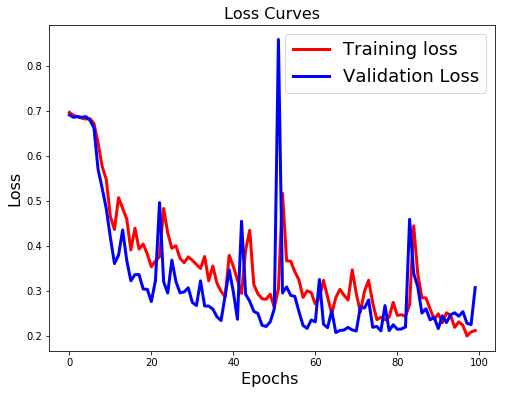

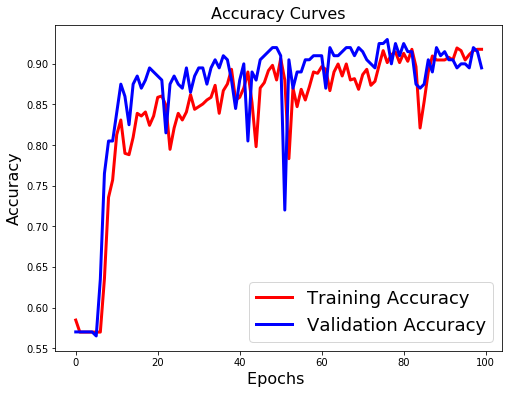

In [106]:
batch_size = 100
epochs = 100

datagen = ImageDataGenerator(
        zoom_range=0.1,        # randomly zoom into images
        rotation_range=5,      # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,# randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False    # randomly flip images
)
 

def is_binary(model):
    n_classes = model.get_layer('output').output_shape[1]
    return n_classes == 1
    
def compile_model(model):
    assert(K.image_data_format() == 'channels_last')
    
    if is_binary(model):
        loss= keras.losses.binary_crossentropy
    else:
        loss=keras.losses.categorical_crossentropy
    
    model.compile(
        loss=loss,
#         optimizer=keras.optimizers.Adadelta(),
#         optimizer='rmsprop',
        optimizer=keras.optimizers.Adam(),        
        metrics=['accuracy']
    )

def train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    compile_model(model)
    
    history = model.fit(X_train, Y_train_tmp,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, Y_test)
           )
    return history

def train_gen(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    compile_model(model)
    
    history = model.fit_generator(
        datagen.flow(X_train,
                     Y_train,
                     batch_size=batch_size
        ),
        steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
        epochs=epochs,
        validation_data=(X_test, Y_test),
        workers=4
    )
    return history
# history = train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs)
history = train_gen(model, Xtrain, Ytrain_oh, Xvalid, Yvalid_oh, batch_size, epochs)


show_train_curves(history)

In [ ]:
# Y_train = np.argmax(Y_train, axis=1)
# Y_test = np.argmax(Y_test, axis=1)

In [110]:
train_score = model.evaluate(Xtrain, Ytrain_oh, verbose=1)
print('Train loss:', round(train_score[0], 3))
print(f'Train accuracy: {round(train_score[1] * 100, 2)}%')

valid_score = model.evaluate(Xvalid, Yvalid_oh, verbose=1)
print('Test loss:', round(valid_score[0], 3))
valid_acc_str = f'{round(valid_score[1] * 100, 2)}%'
print(f'Test accuracy: {valid_acc_str}')


609/609 [==============================] - 13s 21ms/step
Train loss: 0.227
Train accuracy: 91.79%
200/200 [==============================] - 4s 20ms/step
Test loss: 0.307
Test accuracy: 89.5%


In [113]:
print(f"types: {classes}")

print("train predictions, truth")
predictions_train =  model.predict(Xtrain, verbose=1)
show_prediction_list(predictions_train, Ytrain_oh)

print("test predictions, truth")
predictions_valid = model.predict(Xvalid, verbose=1)
show_prediction_list(predictions_valid, Yvalid_oh)

types: ['aanvraag', 'other']
train predictions, truth
609/609 [==============================] - 8s 13ms/step
index:      [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
expected:   [0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0]
test predictions, truth
200/200 [==============================] - 2s 12ms/step
index:      [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
expected:   [0 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0]


SU10103967_00001


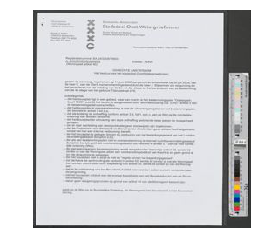

In [114]:
idx = 11
print(ids_test[idx])
show_image(Xvalid, idx)

test set:


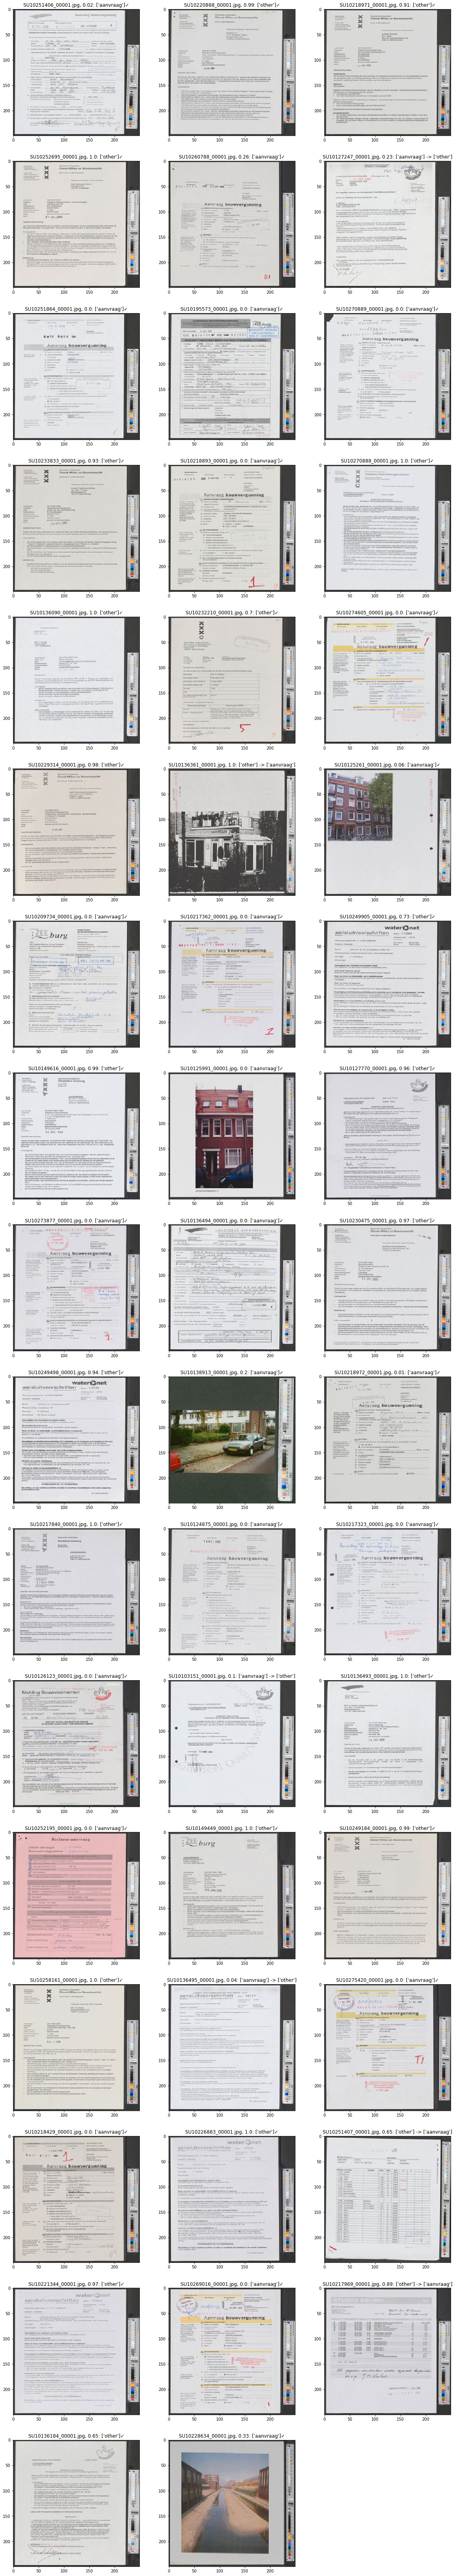

In [149]:
# Y_train_idx = np.argmax(Y_train, axis=1)        
# Y_test_idx = np.argmax(Y_test, axis=1)

# print("train set:")
# show_prediction_images_new(Xtrain, Ytrain_oh, predictions_train, Ytrain_meta, enc, 10)

print("test set:")
show_prediction_images_new(Xvalid, Yvalid_oh, predictions_valid, Yvalid_meta, enc, 50)

In [ ]:
# def multi_class_to_binary(class_true: np.ndarray, class_pred: np.ndarray):
#     # Converting to probablilty that Y_true == 1
#     assert class_true.shape[1] == 2  # 2 classes
#     assert class_pred.shape[1] == 2  # 2 classes
#     assert class_true.shape[0] == class_pred.shape[0]
    
#     y_true = np.argmax(class_true, axis=1)
    
# #     pred_ids = np.argmax(class_pred, axis=1)
# #     y_prob = class_pred[range(class_pred.shape[0]), pred_ids]
#     y_prob = class_pred[:, 1]
#     assert y_true.shape == y_prob.shape
#     return [y_true, y_prob]
    
# [y_true, y_prob] = multi_class_to_binary(Y_test, predictions_test)


In [144]:
print(Yvalid[0:20])
print(np.round(predictions_valid[0:20], 3))
predictions_valid.shape
# print(np.round(y_prob[0:10], 3))

['aanvraag' 'other' 'other' 'other' 'aanvraag' 'other' 'aanvraag'
 'aanvraag' 'aanvraag' 'other' 'aanvraag' 'other' 'other' 'other'
 'aanvraag' 'other' 'aanvraag' 'aanvraag' 'aanvraag' 'aanvraag']
[[0.023]
 [0.994]
 [0.911]
 [0.996]
 [0.26 ]
 [0.235]
 [0.002]
 [0.   ]
 [0.001]
 [0.928]
 [0.001]
 [1.   ]
 [0.999]
 [0.696]
 [0.001]
 [0.98 ]
 [0.997]
 [0.055]
 [0.004]
 [0.001]]


(200, 1)

In [142]:
# class_pred = predictions_test
# pred_ids = np.argmax(class_pred, axis=1)
# y_prob = class_pred[range(class_pred.shape[0]), pred_ids]
y_prob = predictions_valid

In [145]:
# reference https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

n_bins = 5

print(f'accuracy: {test_acc_str}')
conf_avg = np.average(predictions_test)
conf_avg_str = f'{round(conf_avg * 100, 2)}%'
print(f'confidence avg: {conf_avg_str}')

def draw_confidence_histogram(y_prob, n_bins):
    plt.figure()
    plt.title('Confidence histogram')
    plt.xlabel("Confidence")
    plt.ylabel("Sample count")
    plt.hist(y_prob, bins=n_bins)    
draw_confidence_histogram(y_prob, n_bins=n_bins)

def draw_reliability_curve(y_true, y_prob, n_bins):
    plt.figure()
    plt.title('Reliability curve')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    [prob_true_bins, prob_pred_bins] = calibration_curve(y_true, y_prob, n_bins=n_bins)

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred_bins, prob_true_bins, marker='s')
draw_reliability_curve(y_true, y_prob, n_bins)


NameError: name 'test_acc_str' is not defined